In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import warnings
warnings.filterwarnings('ignore')

题目：对给定的A股指数和债券指数，进行固定比例的股债再平衡投资，对比不进行再平衡的投资效果。
- 固定比例指的是投资开始时资产占比的比例给定，比如股票指数占比10%债券指数占比90%。「code中 bond_pct代表债券占比」
- 再平衡指的是，固定周期（每隔数月或数年），将因为涨跌偏离固定比例的资产调回固定比例。「code中 rebalance_cycle代表再平衡周期（单位：天）」
- 尝试计算不同股债比例、不同投资时长（比如1、3、5、7、10年）、不同周期再平衡、不同时间入场的投资效果。
- 暂时不考虑费率因素。

作业分为三部分：

第一部分、实现再平衡策略

第二部分、必做题

第三部分、选做题

# 第一部分 实现再平衡策略，参数调优

In [2]:
def preprocess(data,start,end):
    
    """预处理数据集：1、根据回测起始、结束时间切割数据集；2、normalize每个指数，方便后续计算
         data : 数据集
         start : 回测起始时间
         end : 回测结束时间"""
    
    start_idx = data[data['时间'] == start].index.values[0]
    end_idx = data[data['时间'] == end].index.values[0]
    data = data.loc[start_idx:end_idx,:]
    
    data['hs_net'] = data['沪深300']/data['沪深300'].iloc[0]
    data['zz_net'] = data['中证500']/data['中证500'].iloc[0]
    #data['wind_net'] = data['万得全A']/data['万得全A'].iloc[0] 因为不存在追踪万得全A的指数基金，就暂时不考虑该指数
    data['bond_net'] = data['中债-综合财富(总值)指数']/data['中债-综合财富(总值)指数'].iloc[0]
    
    return data

In [3]:
def rebalance(data,start,end,bond_pct,capital_base,rebalance_cycle):
    
    """rebalance_cycle : 再平衡周期(以一年252个交易日计算)
       start : 回测起始时间
       end : 回测结束时间
       bond_pct : 债券基金占比
       capital_base : 起始资金
       「为了简化，该策略默认投资股市的资金平均投给沪深300和中证500指数基金」"""
    
    #再平衡调仓时间
    rebalance_idx = []
    rebalance_idx.append(data[data['时间'] == start].index.values[0])#把入场时间记为第一次调仓时间
    #初始的债券基金net
    bond_price = data[data['时间'] == start]['bond_net'].iloc[0]
    #初始大小盘股票指数基金net
    bigstock_price = data[data['时间'] == start]['hs_net'].iloc[0]
    smallstock_price = data[data['时间'] == start]['zz_net'].iloc[0]
    #债券基金持仓份额
    bond_pos = []
    bond_pos.append(capital_base*bond_pct/bond_price)#记录初始入场债基持仓
    #HS300指数基金持仓份额
    bigstock_pos = []
    bigstock_pos.append(capital_base*(1-bond_pct)/(2 * bigstock_price))#记录初始入场HS300指数基金持仓
    #ZZ500指数基金持仓份额
    smallstock_pos = []
    smallstock_pos.append(capital_base*(1-bond_pct)/(2 * smallstock_price))#记录初始入场ZZ500指数基金持仓
    #gap为回测开始时间至回测结束时间之间的交易日
    gap = data[data['时间'] == end].index.values[0]-data[data['时间'] == start].index.values[0]
    
    for i in range(1,int(np.trunc(gap/rebalance_cycle))+1):
        #计算下一次再平衡日
        re_idx = rebalance_idx[0] + rebalance_cycle*i
        rebalance_idx.append(re_idx)
        #下一次再平衡日的债券基金和股票指数基金的net
        bond_price = data['bond_net'].loc[re_idx]
        bigstock_price = data['hs_net'].loc[re_idx]
        smallstock_price = data['zz_net'].loc[re_idx]
        #计算再平衡日时的各资产价值
        bond_value = bond_price * bond_pos[-1]
        bigstock_value = bigstock_price * bigstock_pos[-1]
        smallstock_value = smallstock_price * smallstock_pos[-1]
        #计算各资产的持仓
        bond_pos.append((bond_value+bigstock_value+smallstock_value)*bond_pct/bond_price)
        bigstock_pos.append((bond_value+bigstock_value+smallstock_value)*(1-bond_pct)/(2 * bigstock_price))
        smallstock_pos.append((bond_value+bigstock_value+smallstock_value)*(1-bond_pct)/(2 * smallstock_price))
        
    return rebalance_idx,bond_pos,bigstock_pos,smallstock_pos

In [26]:
def results(data,start,end,bond_pct,capital_base,rebalance_cycle):
    
    """为结果展示"""
    
    idx,bond_pos,bigstock_pos,smallstock_pos = rebalance(data,start,end,bond_pct,capital_base,rebalance_cycle)
    df = pd.DataFrame(np.c_[idx,bond_pos,bigstock_pos,smallstock_pos]).set_index(0).rename(
    columns = {1:'bond_pos',2:'bigstock_pos',3:'smallstock_pos'})
    new_df = data.join(df,how = 'outer')
    new_df = new_df[new_df.index.values >= idx[0]]
    new_df = new_df[new_df.时间 <= end]
    new_df['bond_pos'].fillna(method = 'ffill',inplace = True)
    new_df['bigstock_pos'].fillna(method = 'ffill',inplace = True)
    new_df['smallstock_pos'].fillna(method = 'ffill',inplace = True)
    new_df['strategy'] = new_df['bond_pos']*new_df['bond_net'] + new_df['bigstock_pos']*new_df['hs_net'] + new_df['smallstock_pos']*new_df['zz_net']
    new_df['HS'] =(capital_base/new_df['hs_net'].iloc[0])*new_df['hs_net']
    new_df['ZZ'] =(capital_base/new_df['zz_net'].iloc[0])*new_df['zz_net']
    new_df['Bond'] =(capital_base/new_df['bond_net'].iloc[0])*new_df['bond_net']
    
    return new_df

In [27]:
def evaluate_strategy(data,start,end,strategy):
    
    """计算策略的年化收益、年化波动率、最大回撤"""
    
    trade_days = datetime.datetime.strptime(end,'%Y-%m-%d') - datetime.datetime.strptime(start,'%Y-%m-%d')
    #计算年化收益
    annual_return = (data[strategy].iloc[-1] **(365/(trade_days.days)))-1
    #计算年化波动率
    data['return'] = np.log(data[strategy].shift(1)/data[strategy])
    daily_std = np.std(data['return'])#计算收益率的标准差
    annual_std = np.sqrt(252)*daily_std
    #计算当日之前的资金曲线的最高点
    data['max_values'] = data[strategy].expanding().max()
    #计算与之前最高点的回撤
    data['retracement'] = data[strategy]/data['max_values'] -1
    max_retrace = data.sort_values(by ='retracement').iloc[0]['retracement']
                     
    return annual_return,annual_std,max_retrace

## 一、固定进出场时间，观察股债占比和再平衡周期对投资收益的影响

In [195]:
#读取数据
data = pd.read_csv('指数行情序列.csv')
#设置回测参数
start = '2006-12-29'                      
end = '2021-2-10'                      
capital_base = 1                       # 起始资金
#rebalance_cycle = 126                  #再平衡周期（以一年252个交易日计算）
#bond_pct = 0.5                         #债券指数占比
#先默认大小盘指数的资产占比是1:1
df = preprocess(data,start,end)

### 1、固定再平衡周期，观察不同的股债占比的影响

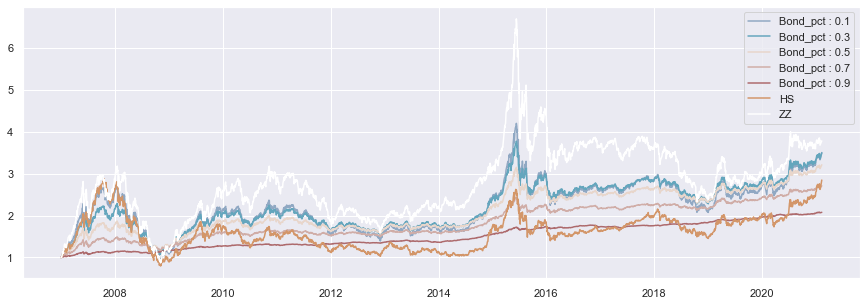

In [67]:
#以一年252个交易日计算
rebalance_cycle = 126
#债券占比
bond_pct = [0.1,0.3,0.5,0.7,0.9]

#可视化收益和风险
color = ['#90A8C3','#64A6BD','#E8D6CB','#D0ADA7','#AD6A6C']
sns.set(rc={'figure.figsize':(15, 5)})
for i in range(len(bond_pct)):
    new_df = results(df,start,end,bond_pct[i],capital_base,rebalance_cycle)
    sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['strategy'].values,label = 'Bond_pct : {}'.format(bond_pct[i]),
                 color= color[i])
    
#将HS300指数作为benchmark
sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['HS'].values,label = 'HS',
                 color= '#d39669')
sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['ZZ'].values,label = 'ZZ',
                 color= 'white')
plt.show()

债券占比越大，曲线越平稳，资产组合的风险越小。债券占比越小，似乎资产组合的年化收益率越高。

年化收益率最高的债券占比： 0.2
最高年化收益率： 0.09
对应年化波动率： 0.23
对应夏普率： 0.28
 
夏普比率最高的债券占比： 0.9
对应年化收益率： 0.05
对应年化波动率： 0.03
最高夏普率： 0.71


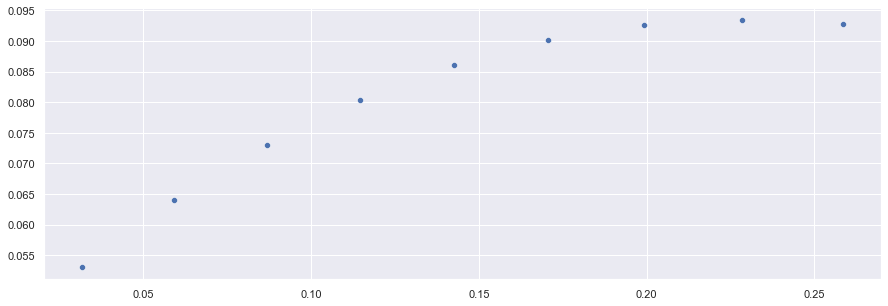

In [78]:
#以一年252个交易日计算
rebalance_cycle = 126
#债券占比
bond_pct = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

annual_return = []
annual_vol = []
sharp_ratio = []
for i in range(len(bond_pct)):
    df_len = preprocess(data,start,end)
    new_df = results(df_len,start,end,bond_pct[i],capital_base,rebalance_cycle)
    annual_return.append(evaluate_strategy(new_df,start,end,'strategy')[0])
    annual_vol.append(evaluate_strategy(new_df,start,end,'strategy')[1])
    sharp_ratio.append((evaluate_strategy(new_df,start,end,'strategy')[0] - 0.0304)/evaluate_strategy(new_df,start,end,'strategy')[1])
    
sns.scatterplot(x=annual_vol, y=annual_return)
print('年化收益率最高的债券占比：',bond_pct[np.argsort(annual_return)[-1]])
print('最高年化收益率：',np.round(np.max(annual_return),2))
print('对应年化波动率：',np.round((annual_vol[np.argsort(annual_return)[-1]]),2))
print('对应夏普率：',np.round((sharp_ratio[np.argsort(annual_return)[-1]]),2))
print(' ')
print('夏普比率最高的债券占比：',bond_pct[np.argsort(sharp_ratio)[-1]])
print('对应年化收益率：',np.round(annual_return[np.argsort(sharp_ratio)[-1]],2))
print('对应年化波动率：',np.round((annual_vol[np.argsort(sharp_ratio)[-1]]),2))
print('最高夏普率：',np.round((np.max(sharp_ratio)),2))
plt.show()

### 2、固定股债占比，观察不同再平衡周期的影响

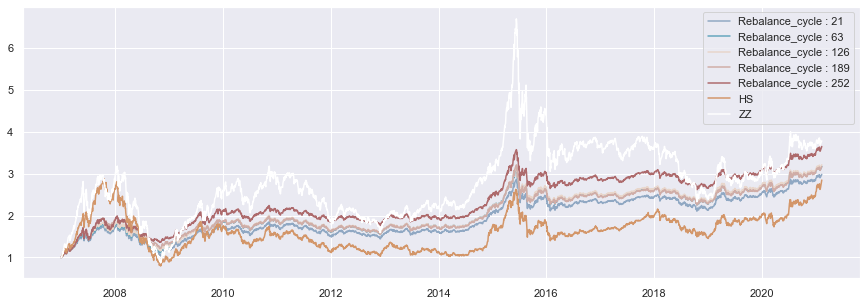

In [188]:
#以一年252个交易日计算
rebalance_cycle = [21,63,126,189,252]
#债券占比
bond_pct = 0.5

#可视化收益和风险
color = ['#90A8C3','#64A6BD','#E8D6CB','#D0ADA7','#AD6A6C','black']
sns.set(rc={'figure.figsize':(15, 5)})
for i in range(len(rebalance_cycle)):
    new_df = results(df,start,end,bond_pct,capital_base,rebalance_cycle[i])
    sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['strategy'].values,label = 'Rebalance_cycle : {}'.format(rebalance_cycle[i]),
                 color= color[i])
    
#将HS300指数作为benchmark
sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['HS'].values,label = 'HS',
                 color= '#d39669')
sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['ZZ'].values,label = 'ZZ',
                 color= 'white')
plt.show()

年化收益率最高的再平衡周期： 252
最高年化收益率： 0.1
对应年化波动率： 0.14
对应夏普率： 0.46
 
夏普比率最高的再平衡占比： 252
对应年化收益率： 0.1
对应年化波动率： 0.14
最高夏普率： 0.46


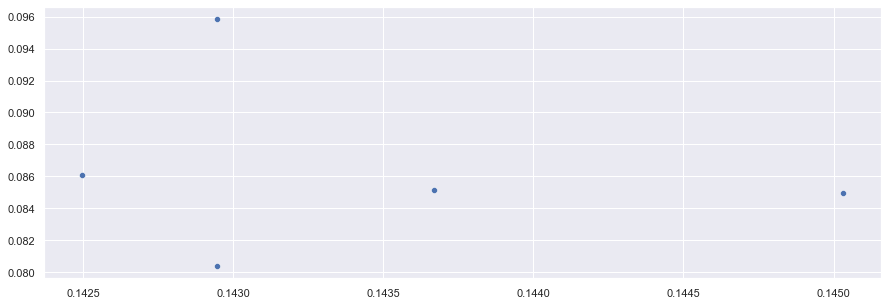

In [74]:
#以一年252个交易日计算
rebalance_cycle = [21,63,126,189,252]
#债券占比
bond_pct = 0.5


annual_return = []
annual_vol = []
sharp_ratio = []
for i in range(len(rebalance_cycle)):
    df_len = preprocess(data,start,end)
    new_df = results(df_len,start,end,bond_pct,capital_base,rebalance_cycle[i])
    annual_return.append(evaluate_strategy(new_df,start,end,'strategy')[0])
    annual_vol.append(evaluate_strategy(new_df,start,end,'strategy')[1])
    sharp_ratio.append((evaluate_strategy(new_df,start,end,'strategy')[0] - 0.0304)/evaluate_strategy(new_df,start,end,'strategy')[1])
    
sns.scatterplot(x=annual_vol, y=annual_return)
print('年化收益率最高的再平衡周期：',rebalance_cycle[np.argsort(annual_return)[-1]])
print('最高年化收益率：',np.round(np.max(annual_return),2))
print('对应年化波动率：',np.round((annual_vol[np.argsort(annual_return)[-1]]),2))
print('对应夏普率：',np.round((sharp_ratio[np.argsort(annual_return)[-1]]),2))
print(' ')
print('夏普比率最高的再平衡占比：',rebalance_cycle[np.argsort(sharp_ratio)[-1]])
print('对应年化收益率：',np.round(annual_return[np.argsort(sharp_ratio)[-1]],2))
print('对应年化波动率：',np.round((annual_vol[np.argsort(sharp_ratio)[-1]]),2))
print('最高夏普率：',np.round((np.max(sharp_ratio)),2))
plt.show()

## 二、固定股债占比和再平衡周期，观察入场时机和投资期限的影响

In [177]:
#不同投资期限和入场时间比较
start = '2007-4-12'
end = ['2008-4-14','2010-4-14','2012-4-13','2014-4-14','2017-4-14','2019-4-15']         
bond_pct = 0.5
rebalance_cycle = 252
annual_return = []
annual_vol = []
time = []
for i in range(len(end)):
    df_len = preprocess(data,start,end[i])
    new_df = results(df_len,start,end[i],bond_pct,capital_base,rebalance_cycle)
    delta = datetime.datetime.strptime(end[i],'%Y-%m-%d') - datetime.datetime.strptime(start,'%Y-%m-%d') 
    year = np.int(delta.days/365)
    time.append(year)
    annual_return.append(evaluate_strategy(new_df,start,end[i],'strategy')[0])
    annual_vol.append(evaluate_strategy(new_df,start,end[i],'strategy')[1])
print('入场时间：',start)
ans = pd.DataFrame(np.c_[annual_return,annual_vol,time]).rename(columns = {0:'年化收益率',1:'年化波动率',2:
                                                                          '投资期限（年）'})
ans

入场时间： 2007-4-12


,年化收益率,年化波动率,投资期限（年）
0,0.053309,0.242958,1.0
1,0.069515,0.201038,3.0
2,0.016928,0.174938,5.0
3,0.015491,0.157989,7.0
4,0.047164,0.158540,10.0
5,0.043697,0.149764,12.0


In [182]:
#不同投资期限和入场时间比较
start = '2006-4-12'
end = ['2008-4-14','2010-4-14','2012-4-13','2014-4-14','2017-4-14','2019-4-15']         
bond_pct = 0.5
rebalance_cycle = 252
annual_return = []
annual_vol = []
time = []
for i in range(len(end)):
    df_len = preprocess(data,start,end[i])
    new_df = results(df_len,start,end[i],bond_pct,capital_base,rebalance_cycle)
    delta = datetime.datetime.strptime(end[i],'%Y-%m-%d') - datetime.datetime.strptime(start,'%Y-%m-%d') 
    year = np.int(delta.days/365)
    time.append(year)
    annual_return.append(evaluate_strategy(new_df,start,end[i],'strategy')[0])
    annual_vol.append(evaluate_strategy(new_df,start,end[i],'strategy')[1])
    
print('入场时间：',start)
ans = pd.DataFrame(np.c_[annual_return,annual_vol,time]).rename(columns = {0:'年化收益率',1:'年化波动率',2:
                                                                          '投资期限（年）'})
ans

入场时间： 2006-4-12


,年化收益率,年化波动率,投资期限（年）
0,0.465887,0.212854,2.0
1,0.257333,0.193985,4.0
2,0.142622,0.174403,6.0
3,0.108491,0.159877,8.0
4,0.112490,0.159336,11.0
5,0.099356,0.151222,13.0


In [179]:
#不同投资期限和入场时间比较
start = '2008-4-14'
end = ['2010-4-14','2012-4-13','2014-4-14','2017-4-14','2019-4-15']         
bond_pct = 0.5
rebalance_cycle = 252
annual_return = []
annual_vol = []
time = []
for i in range(len(end)):
    df_len = preprocess(data,start,end[i])
    new_df = results(df_len,start,end[i],bond_pct,capital_base,rebalance_cycle)
    delta = datetime.datetime.strptime(end[i],'%Y-%m-%d') - datetime.datetime.strptime(start,'%Y-%m-%d') 
    year = np.int(delta.days/365)
    time.append(year)
    annual_return.append(evaluate_strategy(new_df,start,end[i],'strategy')[0])
    annual_vol.append(evaluate_strategy(new_df,start,end[i],'strategy')[1])
    
print('入场时间：',start)
ans = pd.DataFrame(np.c_[annual_return,annual_vol,time]).rename(columns = {0:'年化收益率',1:'年化波动率',2:
                                                                          '投资期限（年）'})
ans

入场时间： 2008-4-14


,年化收益率,年化波动率,投资期限（年）
0,0.080500,0.179502,2.0
1,0.010147,0.153451,4.0
2,0.011179,0.139100,6.0
3,0.047363,0.146028,9.0
4,0.043852,0.138192,11.0


In [193]:
#不同投资期限和入场时间比较
start = '2010-4-14'
end = ['2012-4-13','2014-4-14','2017-4-14','2019-4-15','2020-4-13']         
bond_pct = 0.5
rebalance_cycle = 252
annual_return = []
annual_vol = []
time = []
for i in range(len(end)):
    df_len = preprocess(data,start,end[i])
    new_df = results(df_len,start,end[i],bond_pct,capital_base,rebalance_cycle)
    delta = datetime.datetime.strptime(end[i],'%Y-%m-%d') - datetime.datetime.strptime(start,'%Y-%m-%d') 
    year = np.int(delta.days/365)
    time.append(year)
    annual_return.append(evaluate_strategy(new_df,start,end[i],'strategy')[0])
    annual_vol.append(evaluate_strategy(new_df,start,end[i],'strategy')[1])
    
print('入场时间：',start)
ans = pd.DataFrame(np.c_[annual_return,annual_vol,time]).rename(columns = {0:'年化收益率',1:'年化波动率',2:
                                                                          '投资期限（年）'})
ans

入场时间： 2010-4-14


,年化收益率,年化波动率,投资期限（年）
0,-0.049629,0.115264,2.0
1,-0.020374,0.108031,4.0
2,0.050576,0.123177,7.0
3,0.044559,0.117361,9.0
4,0.040316,0.117281,10.0


比较了几个不同的入场时间后，发现一个好的入场时间（比如2006年4月）比一个不太好的入场时间（比如2010年4月）总体来说会多出几倍的收益。但即使在一个不太好的时机入场，短期内亏损了，随着投资期限拉长，资产组合也能转亏为盈。

# 第二部分 必做题

#### 1. 股市的风险收益特征是？

高风险高收益。

#### 2. 债市的风险收益特征是？

低风险较低收益

#### 3. 再平衡后对投资效果有提升吗？短期、长期有区别吗？

从图上看，黑色曲线是没有再平衡策略的投资效果。无论在长期还是短期，再平衡策略都一定程度上提高了投资收益。越是长期，再平衡策略的效果越突出

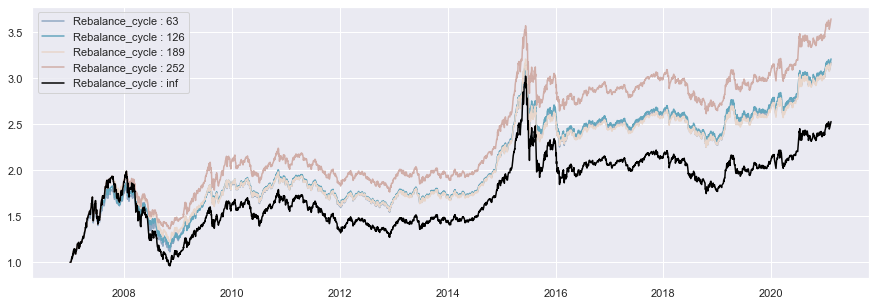

In [205]:
start = '2006-12-29'                      
end = '2021-2-10'                      
capital_base = 1 
#以一年252个交易日计算
rebalance_cycle = [63,126,189,252,np.inf]
#债券占比
bond_pct = 0.5

#可视化收益和风险
color = ['#90A8C3','#64A6BD','#E8D6CB','#D0ADA7','black']
sns.set(rc={'figure.figsize':(15, 5)})
for i in range(len(rebalance_cycle)):
    new_df = results(df,start,end,bond_pct,capital_base,rebalance_cycle[i])
    sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['strategy'].values,label = 'Rebalance_cycle : {}'.format(rebalance_cycle[i]),
                 color= color[i])
    
#将HS300指数作为benchmark
#sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['HS'].values,label = 'HS',
                 #color= '#d39669')
#sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['ZZ'].values,label = 'ZZ',
                 #color= 'white')
plt.show()

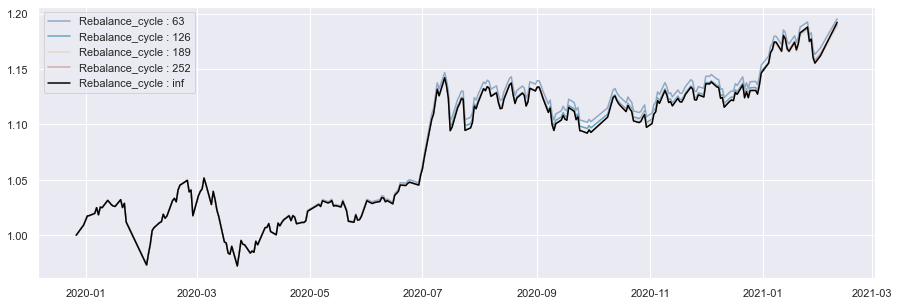

In [206]:
start = '2019-12-27'                      
end = '2021-2-10'                      
capital_base = 1 
#以一年252个交易日计算
rebalance_cycle = [63,126,189,252,np.inf]
#债券占比
bond_pct = 0.5

#可视化收益和风险
color = ['#90A8C3','#64A6BD','#E8D6CB','#D0ADA7','black']
sns.set(rc={'figure.figsize':(15, 5)})
for i in range(len(rebalance_cycle)):
    new_df = results(df,start,end,bond_pct,capital_base,rebalance_cycle[i])
    sns.lineplot(x = pd.to_datetime(new_df['时间'].values), y = new_df['strategy'].values,label = 'Rebalance_cycle : {}'.format(rebalance_cycle[i]),
                 color= color[i])
      
plt.show()

# 第三部分 开放题

### 开放题

#### 1. 如果给自己做一个股债平衡组合，你会怎么设置模型参数？

根据code调优部分的分析，我会选择债券占比20%，再平衡周期为一年的投资组合

#### 2. 股债平衡策略的缺点是？有什么改进方向？

如果市场发生大幅震荡时，股债平衡策略无法及时作出反应。可以修改再平衡机制，把再平衡的触发时机由固定时间周期改为股债资产的偏离度达到一定程度时。

#### 3. 导致债市风险收益特征表现的原因？（参考了黑板报的文章^ ^）

债券的收益主要来自于三个部分：债券的利息收入、资本利得和再投资收益。
其中，票面利率和期限是在债券发行初就设定好的。资本利得由债券价格的浮动产生。债券价格的涨跌主要受利率影响，而利率一般都受到调控，不会大涨大跌。所以债券的收益是比较稳定的。
债券面对的风险主要有：信用风险、利率风险和通胀风险。
债券是刚性兑付，违约风险较小，虽然也存在违约的情况，但总体风险会小于股票。（发行人破产时，债权还是优先于股权）
所以总体来说，相较于股票，债市表现出低风险较低收益的特征。


#### 4. 导致股市风险收益特征表现的原因？（参考了黑板报的文章^ ^）

股票是公司的所有权，收益主要来源于公司的盈利增长，是面向未来的。未来带有相当程度的不确定性，对未来定价，也就导致了股票的不确定性很大，波动性很大。这是股市风险较高的原因。
股市收益高的原因是，依托于公司这个高效率的生产组织，具有规模效应等优点，创造了大量财富，